In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/Colab\ Notebooks

Mounted at /gdrive
/gdrive/MyDrive/Colab Notebooks


In [2]:
%pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48.4 MB 1.9 MB/s 


In [3]:
import torch
import torch.nn as nn
from torchvision import transforms, utils
from torch.utils.data import DataLoader, Dataset
import os
import pandas as pd
import numpy as np
from PIL import Image, ImageOps
from tqdm import tqdm
from tqdm import trange
from torch.optim import Adam
from torch.nn import DataParallel
from model import UNet
from torch.optim.lr_scheduler import MultiStepLR as Scheduler

from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import random
import cv2

import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec
import seaborn as sns

import types
import SimpleITK as sitk

In [38]:
def IoU(y_pre, y_true):
    #y_pre = torch.max(y_pre, 3)
    y_pre = y_pre.int()
    y_true = y_true.int()
    I = torch.bitwise_and(y_pre, y_true).sum().item()
    U = torch.bitwise_or(y_pre, y_true).sum().item()
    if U == 0:
        return 0
    if I > U:
        print('iou counting error')
    return float(I)/U

def IoU_single(y_pre, y_true):
    y_pre = y_pre.flatten().astype(int)
    y_true = y_true.flatten().astype(int)
    I = np.bitwise_and(y_pre, y_true).sum().item()
    U = np.bitwise_or(y_pre, y_true).sum().item()
    if U == 0:
        return 0
    if I > U:
        print('iou counting error')
    return float(I)/U

def IoUAll(y_pre, y_true):
    num = int(256 * 256)
    y_pre = y_pre.int()
    y_true = y_true.int()
    length = y_pre.size()[0]
    assert(length%num==0)
    pic_num = int(length / num)
    IoUList = []
    for i in range(pic_num):
        pre = y_pre[num*i:num*(i+1)]
        true = y_true[num*i:num*(i+1)]
        iou = IoU(pre, true)
        IoUList.append(iou)
    return np.mean(IoUList)

def get_area(labels):
    num = int(256 * 256)
    label = labels.view(-1).int()
    length = label.size()[0]
    assert(length%num==0)
    pic_num = int(length / num)
    sizeList = []
    for i in range(pic_num):
        size = torch.sum(label[num*i:num*(i+1)]).item()
        sizeList.append(size)
    return sizeList

def test_model(loader, model_t, size=0):
    model = UNet(num_classes=2, in_channels=1)
    model.cuda()
    model = DataParallel(model)
    model.load_state_dict(torch.load(model_t))
    model.eval()
    IoUSum = 0
    IoUList = []
    annoList = []
    picList = []
    sizeList = []
    oriList = []
    for i, data in enumerate(loader):
        inputs, labels = data[0].cuda(), data[1].cuda()
        outputs = model(inputs)
        _, predicts = torch.max(outputs.permute(0, 2, 3, 1), axis = 3)
        predict = predicts.view(-1)
        iou_s = IoUAll(predict, labels.view(-1))
        IoUSum += iou_s
        IoUList.append(iou_s)
        picList.append(predicts.cpu().detach().numpy())
        annoList.append(labels.cpu().detach().numpy())
        oriList.append(inputs.cpu().detach().numpy())
        sizeList += get_area(labels)
    iou = IoUSum/len(loader)
    print("iou ", iou)
    if size:

        return iou, IoUList, picList, annoList, oriList, sizeList
    else:
        return iou, IoUList, picList, annoList, oriList


def run_epoch(loader, model, loss_fn, optimizer):
    CESum = 0
    LSum = 0
    if optimizer is None:
        model.eval()
    else:
        model.train()

    for data in loader:
        inputs, labels = data[0].cuda(), data[1].cuda()
        outputs = model(inputs)
        if optimizer is not None:
            optimizer.zero_grad()
            loss = 0.0
            output = outputs.permute(2, 3, 0, 1).contiguous().view(-1, 2)
            label = labels.permute(1, 2, 0).contiguous().view(-1)
            loss = loss_fn(output, label)
            loss.backward()
            optimizer.step()
            LSum += loss.item()

        _, predicts = torch.max(outputs.permute(0, 2, 3, 1), axis = 3)
        predict = predicts.view(-1)
        CESum += IoUAll(predict, labels.view(-1))
    acc = CESum/len(loader)
    return acc, LSum

def testProcess(pt, range):
    torch.backends.cudnn.benchmark = True
    model =   r'/gdrive/My Drive/result/rysy/{}'.format(pt)
    dataset = r"/gdrive/My Drive/anno/liver_test"
    imgnpy = "liver_test2.npy"
    train = liverDataset(dataset, imgnpy, imgRange = range) 

    print('len', len(train))
    train_loader = DataLoader(dataset = train, batch_size = 1, shuffle = False, drop_last = True)
    IoUAve, IoUList, picList, annoList, oriList = test_model(train_loader, model)
    return IoUAve, IoUList, picList, annoList, oriList
    

class liverDataset (Dataset):
    def __init__(self, dataset, imgnpy, size = 256, imgRange = None, transform = None):
        self.dataset = dataset
        self.imgnpy = imgnpy
        self.size = size
        self.imgRange = imgRange
        self.transform = transform

    def __getitem__(self, i):
        imgList = np.load('{}/{}'.format(self.dataset, self.imgnpy), allow_pickle = True).item()
        if self.imgRange:
            idx = i + self.imgRange[0]
        else:
            idx = i
        imgFolder, imgFile, imgSlice = imgList[idx]

        # imgPath = r"{}/volume_pt{}/volume-{}.nii".format(self.dataset, imgFolder, imgFile)
        imgPath = r"{}/volume-{}.nii".format(self.dataset, imgFile)
        img = sitk.ReadImage(imgPath)
        img = sitk.GetArrayFromImage(img)
        img = img[imgSlice]

        # maskPath = r"{}/segmentations/segmentation-{}".format(self.dataset, imgFile)
        maskPath = r"{}/segmentation-{}".format(self.dataset, imgFile)
        mask = sitk.ReadImage(maskPath)
        mask = sitk.GetArrayFromImage(mask)
        mask = mask[imgSlice]
        
        
        if self.size:
            img = Image.fromarray(img)
            img = img.resize((self.size,self.size))
            img = np.array(img)
            mask = Image.fromarray(mask)
            mask = mask.resize((self.size,self.size))
            # mask = ImageOps.mirror(mask)
            # mask = mask.rotate(90)
            mask = np.array(mask)

        maskShape = mask.shape
        temp = [0 if i == 0 else 1 for i in mask.flatten()]
        mask = np.array(temp).reshape(maskShape)

        img = np.dstack((img))
        Img = torch.tensor(img)
        Mask = torch.tensor(mask)

        return Img.float(), Mask.long()
    
    def __len__(self):
        imgList = np.load('{}/{}'.format(self.dataset, self.imgnpy), allow_pickle = True).item()
        if self.imgRange:
            return self.imgRange[1] - self.imgRange[0]
        else:
            return len(imgList)


In [39]:
IoUAve1, IoUList1, picList1, annoList1, oriList1 = testProcess("liver_2kt_2kv.pt",[0,12])
IoUAve1, IoUList2, picList2, annoList1, oriList2 = testProcess("liver_4kt_2kv.pt",[0,12])

len 12
iou  0.20016123557381152
len 12
iou  0.22607779853773


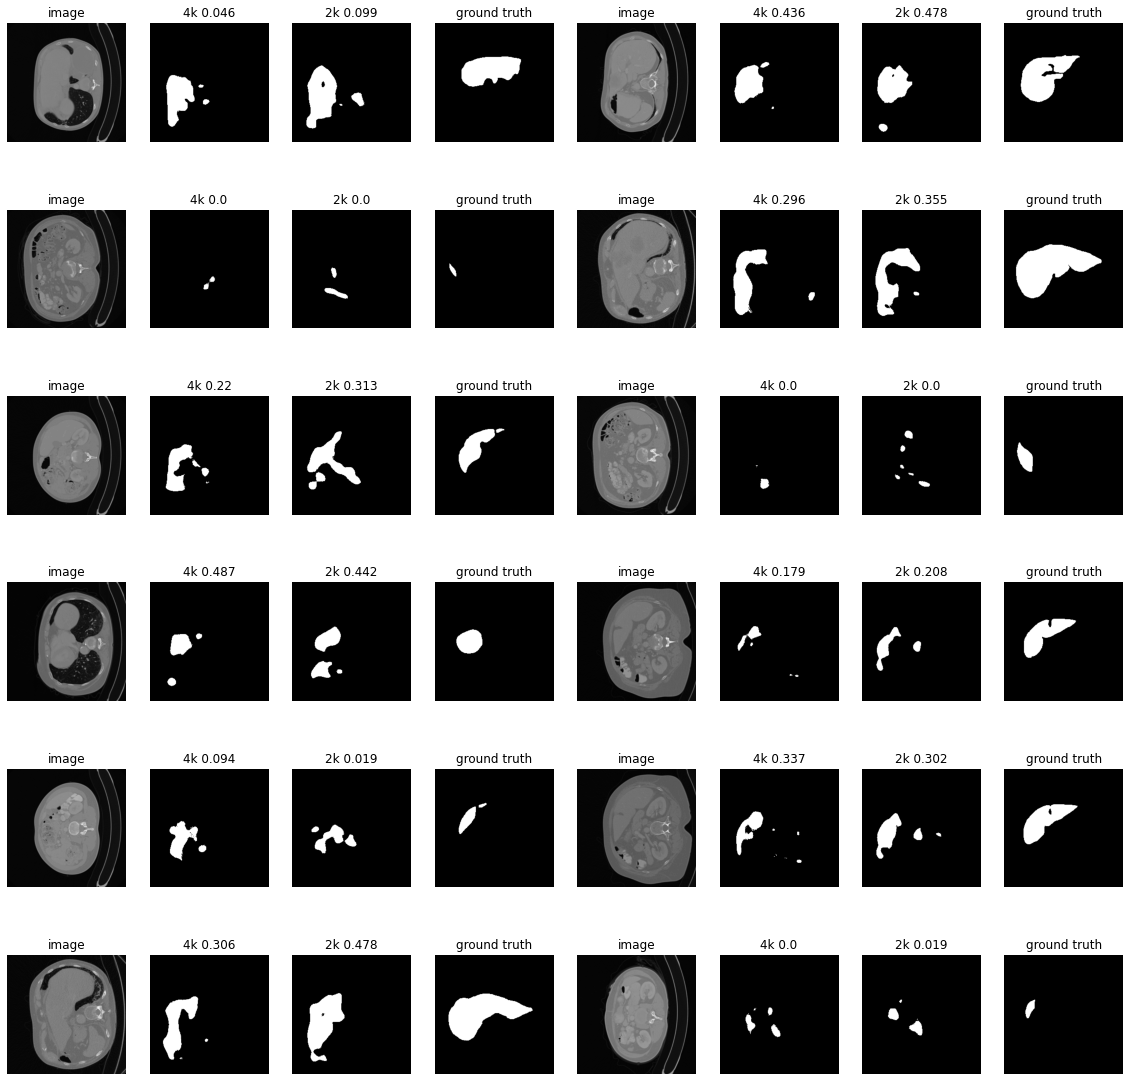

In [40]:
plt.figure(figsize = (20,20))
ct = 1
names = ['4k', '2k']
for p1,p2, a,i1,i2,im in zip(picList1,picList2, annoList1, IoUList1, IoUList2, oriList2):
    img = im[0][0].astype(int)
    plt.subplot(6,8,ct)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('image')
    ct += 1

    plt.subplot(6,8,ct)
    plt.imshow(p1[0], cmap = 'gray')
    plt.title(names[0]+" "+str(np.round(i1, 3)))
    plt.axis('off')
    ct += 1
    plt.subplot(6,8,ct)
    plt.imshow(p2[0], cmap = 'gray')
    plt.title(names[1]+" "+str(np.round(i2, 3)))
    plt.axis('off')
    ct += 1

    plt.subplot(6,8,ct)
    plt.imshow(a[0], cmap = 'gray')
    plt.axis('off')
    ct += 1
    plt.title('ground truth')

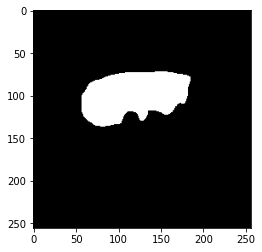

In [23]:
x = annoList1[0][0]
plt.imshow(x, cmap='gray')

In [26]:
print(x)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


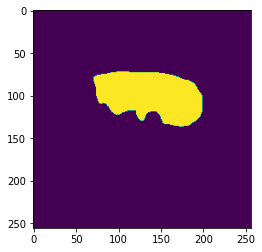

In [33]:
imgx=Image.fromarray(x.astype(np.uint8))
imgy=ImageOps.mirror(imgx)
plt.imshow(imgy)

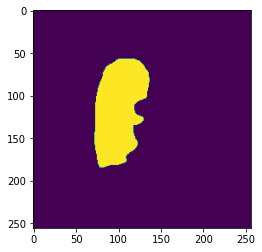

In [34]:
imgz = imgy.rotate(90)
plt.imshow(imgz)

In [7]:
dataset = r"/gdrive/My Drive/anno/liver_test"
imgnpy = "liver_temp.npy"
x = np.load('{}/{}'.format(dataset, imgnpy), allow_pickle = True).item()

In [14]:
np.save('{}/liver_test2.npy'.format(dataset), newDic)

In [12]:
index = np.arange(1493)
random.shuffle(index)
newDic = {}
for i in range(1493):
  newDic[index[i]] = x[i]
for i in range(1493):
  t = newDic[i]

In [13]:
for i in range(12):
  print(newDic[i])

[8, 120, 257]
[8, 124, 233]
[8, 127, 484]
[8, 129, 264]
[8, 120, 194]
[8, 127, 515]
[8, 125, 264]
[8, 126, 201]
[8, 120, 169]
[8, 126, 205]
[8, 129, 278]
[8, 124, 179]


In [19]:
plt.figure(figsize = (20,20))
ct = 1
names = ['4k', '2k']
for p1,p2, a,i1,i2,im in zip(picList1,picList2, annoList1, IoUList1, IoUList2, oriList2):
    img = im[0][0].astype(int)
    plt.subplot(6,8,ct)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('image')
    ct += 1

    plt.subplot(6,8,ct)
    plt.imshow(p1[0], cmap = 'gray')
    plt.title(names[0]+" "+str(np.round(i1, 3)))
    plt.axis('off')
    ct += 1
    plt.subplot(6,8,ct)
    plt.imshow(p2[0], cmap = 'gray')
    plt.title(names[1]+" "+str(np.round(i2, 3)))
    plt.axis('off')
    ct += 1

    plt.subplot(6,8,ct)
    plt.imshow(a[0], cmap = 'gray')
    plt.axis('off')
    ct += 1
    plt.title('ground truth')

NameError: ignored

<Figure size 1440x1440 with 0 Axes>

In [ ]:
print(IoUAve)

0.2203684345807682


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


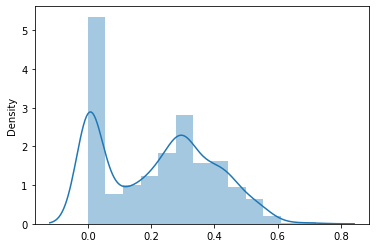

In [ ]:
sns.distplot(IoUList)

In [ ]:
IoUAve, IoUList, picList, annoList = testProcess("liver_2kt_2kv.pt", [0,12])

len 12


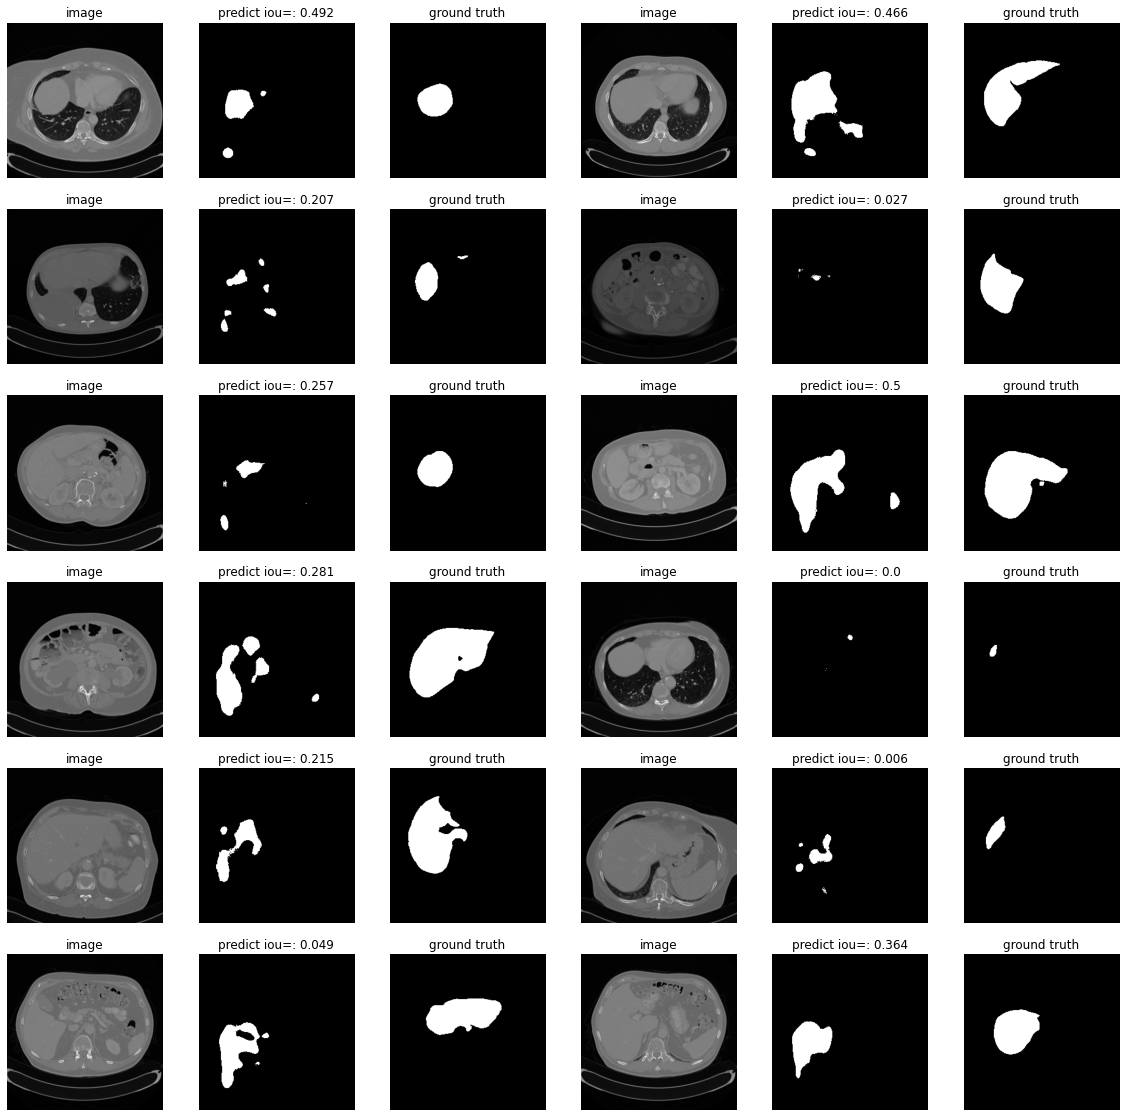

In [ ]:
plt.figure(figsize = (20,20))
ct = 1
dataset = r"/gdrive/My Drive/anno/liver_test"
imgnpy = "liver_test.npy"
imgList = np.load(r"{}/{}".format(dataset, imgnpy), allow_pickle=True).item()
for p,a,i in zip(picList, annoList, IoUList):
    _, imgname, sli = imgList[ct//3]
    file = r"volume-{}.nii".format(imgname)
    img = sitk.ReadImage(os.path.join(dataset, file))
    img = sitk.GetArrayFromImage(img)
    img = img[sli]
    plt.subplot(6,6,ct)
    plt.imshow(img, cmap = 'gray')
    plt.axis('off')
    plt.title('image')
    ct += 1

    plt.subplot(6,6,ct)
    plt.imshow(p[0], cmap = 'gray')
    plt.title("predict iou=: "+str(np.round(i, 3)))
    plt.axis('off')
    ct += 1
    plt.subplot(6,6,ct)
    plt.imshow(a[0], cmap = 'gray')
    plt.axis('off')
    ct += 1
    plt.title('ground truth')

In [ ]:
IoUAve2, IoUList2, picList2, annoList2 = testProcess("liver_4kt_2kv.pt", [0,12])

len 12


FileNotFoundError: ignored

In [ ]:
plt.figure(figsize = (20,20))
ct = 1
path = r"{}/liver_test".format(dataset)
for p,a,i in zip(picList, annoLis, IoUList):
    _, imgname, sli = imgList[ct//3]
    file = r"volume-{}.nii".format(imgname)
    img = sitk.ReadImage(os.path.join(path, file))
    img = sitk.GetArrayFromImage(img)
    img = img[sli]
    plt.subplot(6,6,ct)
    plt.imshow(img, cmap = 'gray')
    plt.axis('off')
    plt.title('image')
    ct += 1

    plt.subplot(6,6,ct)
    plt.imshow(p[0], cmap = 'gray')
    plt.title("predict iou=: "+str(np.round(i, 3)))
    plt.axis('off')
    ct += 1
    plt.subplot(6,6,ct)
    plt.imshow(a[0], cmap = 'gray')
    plt.axis('off')
    ct += 1
    plt.title('ground truth')

In [ ]:
def IoU(y_pre, y_true):
    #y_pre = torch.max(y_pre, 3)
    y_pre = y_pre.int()
    y_true = y_true.int()
    I = torch.bitwise_and(y_pre, y_true).sum().item()
    U = torch.bitwise_or(y_pre, y_true).sum().item()
    if U == 0:
        return 0
    if I > U:
        print('iou counting error')
    return float(I)/U

def IoU_single(y_pre, y_true):
    y_pre = y_pre.flatten().astype(int)
    y_true = y_true.flatten().astype(int)
    I = np.bitwise_and(y_pre, y_true).sum().item()
    U = np.bitwise_or(y_pre, y_true).sum().item()
    if U == 0:
        return 0
    if I > U:
        print('iou counting error')
    return float(I)/U

def IoUAll(y_pre, y_true):
    num = int(256 * 256)
    y_pre = y_pre.int()
    y_true = y_true.int()
    length = y_pre.size()[0]
    assert(length%num==0)
    pic_num = int(length / num)
    IoUList = []
    for i in range(pic_num):
        pre = y_pre[num*i:num*(i+1)]
        true = y_true[num*i:num*(i+1)]
        iou = IoU(pre, true)
        IoUList.append(iou)
    return np.mean(IoUList)

def get_area(labels):
    num = int(256 * 256)
    label = labels.view(-1).int()
    length = label.size()[0]
    assert(length%num==0)
    pic_num = int(length / num)
    sizeList = []
    for i in range(pic_num):
        size = torch.sum(label[num*i:num*(i+1)]).item()
        sizeList.append(size)
    return sizeList

def test_model(loader, model_t, size=0):
    model = UNet(num_classes=2, in_channels=3)
    model.cuda()
    model = DataParallel(model)
    model.load_state_dict(torch.load(model_t))
    model.eval()
    IoUSum = 0
    IoUList = []
    annoList = []
    picList = []
    sizeList = []
    for i, data in enumerate(loader):
        inputs, labels = data[0].cuda(), data[1].cuda()
        outputs = model(inputs)
        _, predicts = torch.max(outputs.permute(0, 2, 3, 1), axis = 3)
        predict = predicts.view(-1)
        iou_s = IoUAll(predict, labels.view(-1))
        IoUSum += iou_s
        IoUList.append(iou_s)
        picList.append(predicts.cpu().detach().numpy())
        annoList.append(labels.cpu().detach().numpy())
        sizeList += get_area(labels)
    iou = IoUSum/len(loader)
    if size:

        return iou, IoUList, picList, annoList, sizeList
    else:
        return iou, IoUList, picList, annoList


def run_epoch(loader, model, loss_fn, optimizer):
    CESum = 0
    LSum = 0
    if optimizer is None:
        model.eval()
    else:
        model.train()

    for data in loader:
        inputs, labels = data[0].cuda(), data[1].cuda()
        outputs = model(inputs)
        if optimizer is not None:
            optimizer.zero_grad()
            loss = 0.0
            output = outputs.permute(2, 3, 0, 1).contiguous().view(-1, 2)
            label = labels.permute(1, 2, 0).contiguous().view(-1)
            loss = loss_fn(output, label)
            loss.backward()
            optimizer.step()
            LSum += loss.item()

        _, predicts = torch.max(outputs.permute(0, 2, 3, 1), axis = 3)
        predict = predicts.view(-1)
        CESum += IoUAll(predict, labels.view(-1))
    acc = CESum/len(loader)
    return acc, LSum

def testProcess(pt, range):
    torch.backends.cudnn.benchmark = True
    model =   r'/gdrive/My Drive/result/rysy/{}'.format(pt)
    dataset = r"/gdrive/My Drive/anno/river_test"
    imgnpy = "river_test.npy"
    train = riverDataset(dataset, imgnpy, imgRange = range) 

    print('len', len(train))
    train_loader = DataLoader(dataset = train, batch_size = 1, shuffle = False, drop_last = True)
    IoUAve, IoUList, picList, annoList = test_model(train_loader, model)
    return IoUAve, IoUList, picList, annoList

class riverDataset (Dataset):
    def __init__(self, dataset, imgnpy, size = 256, imgRange = None, transform = None):
        self.dataset = dataset
        self.imgnpy = imgnpy
        self.size = size
        self.imgRange = imgRange
        self.transform = transform

    def __getitem__(self, i):
        imgList = np.load('{}/{}'.format(self.dataset, self.imgnpy), allow_pickle = True)
        if self.imgRange:
            idx = i + self.imgRange[0]
        else:
            idx = i
        imgFile = imgList[idx]


        imgPath = r"{}/{}".format(self.dataset, imgFile)
        img = Image.open(imgPath)

        maskPath = r"{}/{}.png".format(self.dataset, imgFile[:-4])
        mask = Image.open(maskPath)
        
        if self.size:
            img = img.resize((self.size,self.size))
            img = np.array(img)
            mask = mask.resize((self.size,self.size))
            mask = np.array(mask)
        else:
            img = np.array(img)
            mask = np.array(mask)
        
        mask = mask[:,:,0]
        maskShape = mask.shape
        temp = [0 if it == 0 else 1 for it in mask.flatten()]
        mask = np.array(temp).reshape(maskShape)
        Img = torch.tensor(img)
        Img = Img.permute((2, 0, 1))
        Mask = torch.tensor(mask)

        return Img.float(), Mask.long()
    
    def __len__(self):
        imgList = np.load('{}/{}'.format(self.dataset, self.imgnpy), allow_pickle = True)
        if self.imgRange:
            return self.imgRange[1] - self.imgRange[0]
        else:
            return len(imgList)

In [ ]:
IoUAve2, IoUList2, picList2, annoList2 = testProcess("river_1500t_200v.pt", [0,12])

len 12


In [ ]:
print(IoUAve2)

0.5965184697755257


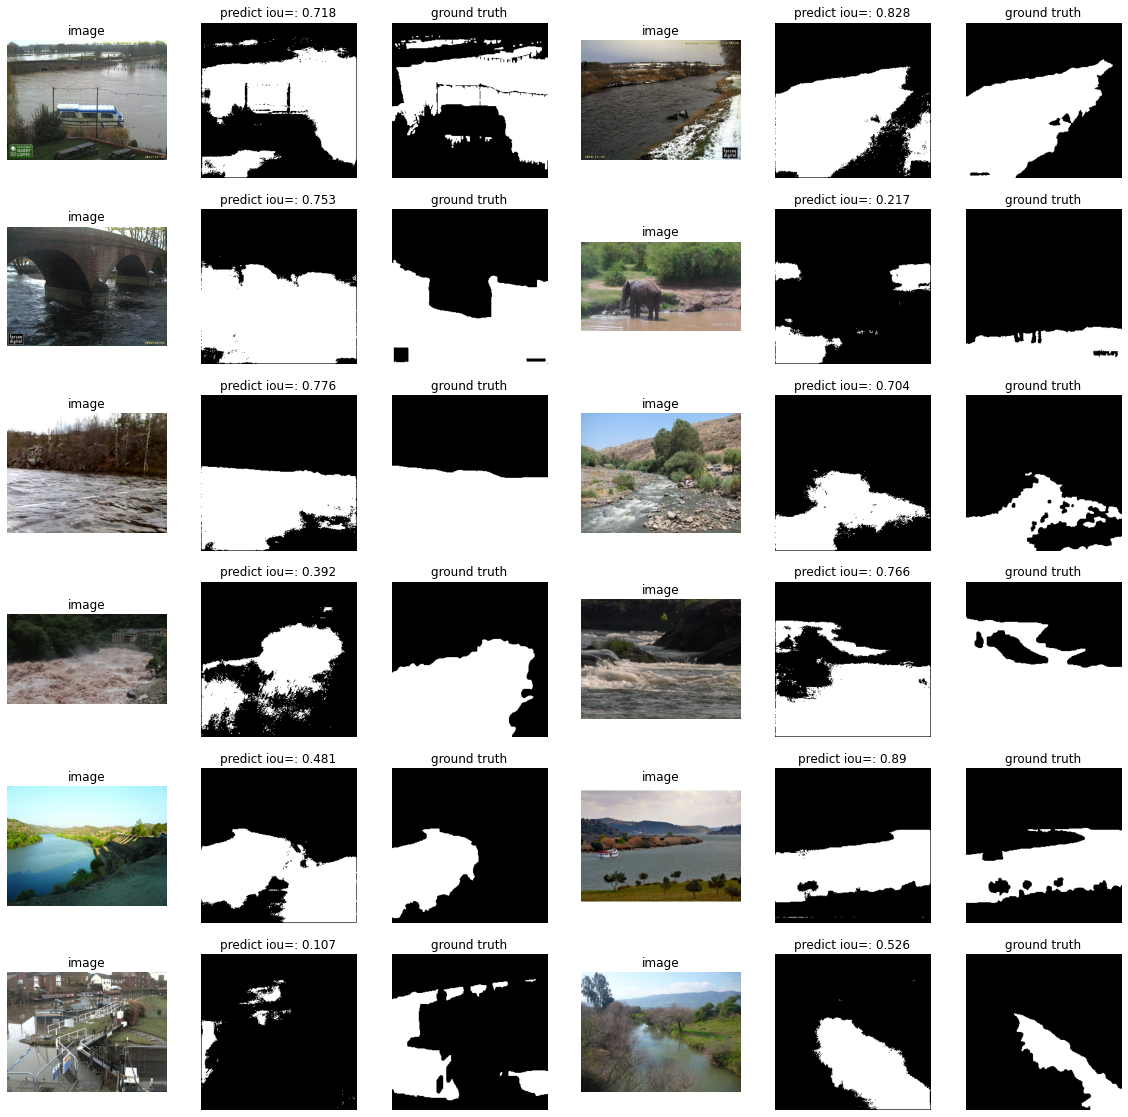

In [ ]:
plt.figure(figsize = (20,20))
ct = 1
dataset = r"/gdrive/My Drive/anno/river_test"
imgnpy = "river_test.npy"
imgList = np.load(r"{}/{}".format(dataset, imgnpy), allow_pickle=True)
for p,a,i in zip(picList2, annoList2, IoUList2):
    imgname = imgList[ct//3]
    img = Image.open(os.path.join(dataset, imgname))
    plt.subplot(6,6,ct)
    plt.imshow(img)
    plt.axis('off')
    plt.title('image')
    ct += 1

    plt.subplot(6,6,ct)
    plt.imshow(p[0], cmap = 'gray')
    plt.title("predict iou=: "+str(np.round(i, 3)))
    plt.axis('off')
    ct += 1
    plt.subplot(6,6,ct)
    plt.imshow(a[0], cmap = 'gray')
    plt.axis('off')
    ct += 1
    plt.title('ground truth')

In [ ]:
dataset = r"/gdrive/My Drive/anno"
imgnpy = "brat_test.npy"
imgList = np.load('{}/{}'.format(dataset, imgnpy), allow_pickle = True).item()

In [ ]:
print(imgList)

{0: ['032', 134], 1: ['338', 83], 2: ['322', 64], 3: ['236', 109], 4: ['293', 65], 5: ['019', 43], 6: ['106', 90], 7: ['312', 123], 8: ['240', 63], 9: ['327', 112], 10: ['339', 124], 11: ['222', 90], 12: ['186', 67], 13: ['036', 95], 14: ['358', 98], 15: ['029', 95], 16: ['071', 77], 17: ['210', 85], 18: ['330', 59], 19: ['304', 42]}


In [ ]:
print(3//2)

1


In [ ]:
x = IoUList * 100
print(len(x))

1200


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'IoU')

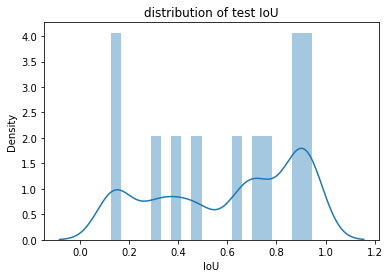

In [ ]:
sns.distplot(x, bins = 20)
plt.title('distribution of test IoU')
plt.xlabel('IoU')

In [ ]:
print(IoUList)

[0.7017082785808147, 0.871306005719733, 0.48628987129266926, 0.9462823452341959, 0.15817460317460316, 0.29346314325452016, 0.12636695018226002, 0.9298000929800093, 0.8877419354838709, 0.7594093804284887, 0.3867141162514828, 0.6429725363489499]


In [ ]:
%pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48.4 MB 31 kB/s 
